In [15]:
import libsparse as sp

sparse matrices
===============

Sparse matrices are matrices that are mostly empty i.e. zeros.

An Example for these matrices would be in the ODE of a linear chain with 6 elements.
The Equation to solve these systems is called *Hook's Law*:
$-\ddot{x}=\mathbf{\kappa} x$
$$
\kappa =
\begin{pmatrix}
2 & -1 & 0 & 0 & 0 & 0\\
-1 & 2 & -1 & 0 & 0 & 0\\
0 & -1 & 2 & -1 & 0 & 0\\
0 & 0 & -1 & 2 & -1 & 0\\
0 & 0 & 0 & -1 & 2 & -1\\
0 & 0 & 0 & 0 & -1 & 2
\end{pmatrix}
$$

As one can see, most of the elements in this matrix are zero.

In these type of problems and in many more, these matrices can get very large and memory intensive. We therefore need a way of working with these low density matrices in a memory efficient way.

The solution is to not store the redundant zeros.

Storage scheme
---------------
Not storing the zeros can be done with a number of different strategies:

- **C**ompressed **S**parse **R**ow     (CSR)
- **C**ompressed **S**parse **C**olumn  (CSC)
- **Li**st of **L**ists                 (LIL)
- **Coo**rdinate List                   (COO)
- ...

In this project we will focus on the CSR format.

The CSR format consists of 3 lists:

|      | 0 |  1 |  2 |  3 |  4 |  5 |  6 |  7 |  8 |  9 |
|:----:|--:|---:|---:|---:|---:|---:|---:|---:|---:|---:|
| AVAL | 2 | -1 | -1 |  2 | -1 | -1 |  2 | -1 | -1 |  2 |
| JCOL | 1 |  2 |  1 |  2 |  3 |  2 |  3 |  4 |  3 |  4 |
| IROW | 0 |  2 |  5 |  8 | 10 |

- AVAL : the values
- JCOL : the index in the matrix where the value from AVAL belongs
- IROW : these are the indices of AVAL or JCOL where a new row begins

Our Project
===========

The task of our project is to implement the storage scheme and necessary mathmatical operations to solve linear systems of equations.
In order to achieve this and as an expansion of this task, our aim was to create a data object which can be used just as seamless as the `scipy.sparse` object.

We therefore needed to develop a class which can be given a standard numpy array and constructs CSR lists as well as providing methods like addition subtraction and mulitplication. These should work on these lists without creating a full-size `numpy.ndarray`.

In addition we devoleped a class to represent linear systems and which implements different methods of solving.


Creating the sparse object with an ndarray:

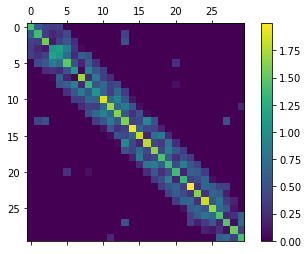

<sparse matrix of shape (30, 30) and density 0.29>

In [16]:
array=sp.random_banded(30,4)

a=sp.sparse(array)
a.show()
a

In [17]:
list(a.__dict__.keys())

['density', 'shape', 'T', 'CSR', 'N']

The instantiated object defines the following attributes `['density', 'shape', 'T', 'CSR', 'N']` of which N is only defined for square matrices, as this would be ambiguous.

To make these objects actually useful, we need to implement the `__getitem__` and `__setitem__` method.

These methods make the object subscribtable which makes them a lot more useful.

In [18]:
print("pre ", a[1,1])
a[1,1] = 2
print("post ",a[1,1])

pre  1.3808241970227058
post  2.0


Using these methods now greatly simplifys the more complicated methods such as `__add__`, `__sub__` and `__matmul__`.

We can now just iterate over both array dimensions and do not need to worry about the CSR lists.
This, however, has implications about performance of the code.

The following test was done using [line-profiler](https://pypi.org/project/line-profiler/) and we can see how much time each line takes to execute.

In [24]:
!python -m line_profiler mdot.lprof

Timer unit: 1e-06 s

Total time: 56.7281 s
File: /home/simon/Git-Repos/sparse-matrices/libsparse.py
Function: _mdot at line 358

Line #      Hits         Time  Per Hit   % Time  Line Contents
   358                                               @profile
   359                                               def _mdot(self, other):
   360                                                   '''
   361                                                   Author: Simon Glennemeier-Marke
   362                                                   '''
   363         1         11.0     11.0      0.0          result = np.zeros((self.shape[0], other.shape[1]))
   364       101         66.0      0.7      0.0          for i in range(self.shape[0]):
   365     10100       6358.0      0.6      0.0              for j in range(other.shape[1]):
   366     10000   26168327.0   2616.8     46.1                  row = self[i, None]
   367     10000   26520198.0   2652.0     46.7                  col = other[None, j

As we can see in the header of each profiled function, the first method is, in this case, 12 times slower to compute a matrix product of two (100x100)-matrices.

Therefore it has to be considered if the time penalty constitutes the logic simplicity. To keep performance high the default behaviour is the `_mdot_fast` method.


Another example of optimization is `construct_CSR`. This method is used to create the CSR lists from a numpy.ndarray.

For this benchmark both functions were being called on a `scipy.sparse` array of size (1000x1000) and as evident, the *fast* method is roughly 10 times faster.

In [26]:
!python -m line_profiler construct_CSR.lprof

Timer unit: 1e-06 s

Total time: 1.25364 s
File: /home/simon/Git-Repos/sparse-matrices/libsparse.py
Function: construct_CSR at line 236

Line #      Hits         Time  Per Hit   % Time  Line Contents
   236                                               @profile
   237                                               def construct_CSR(self, array):
   238                                                   '''
   239                                                   Author: Simon Glennemeier-Marke
   240                                           
   241                                                   Constructs a CSR form of a given array.
   242                                           
   243                                                   Args:
   244                                                   > `array` :  sparse numpy array
   245                                           
   246                                                   Returns:
   247                                

The bulk of the time improvements is due to a change in concepts in which the incoming array is disected. 
The first implementation loops over the two dimensions of the incoming array making the complexity O(n²). This results in a long runtime altough the individual operations are very fast.

For example a simple `if`-statement taking 0.6µs when called 1 million times, results in it taking ~50% of the runtime.

The second implementation uses numpy arrays and indexation to process a whole row at once, making the complexity O(n).
It is however computationally more complex and for smaller arrays we loose this advantage.